In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential


yf.pdr_override()

In [18]:
start = dt.datetime(2010,1,1)
end = dt.datetime(2019,12,31)

df = pdr.get_data_yahoo('TSLA', start ,end)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [20]:
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [21]:
df = df.drop(['Date','Adj Close'], axis = 1)

In [22]:
df.head()

,Open,High,Low,Close,Volume
0,1.266667,1.666667,1.169333,1.592667,281494500
1,1.719333,2.028000,1.553333,1.588667,257806500
2,1.666667,1.728000,1.351333,1.464000,123282000
3,1.533333,1.540000,1.247333,1.280000,77097000
4,1.333333,1.333333,1.055333,1.074000,103003500


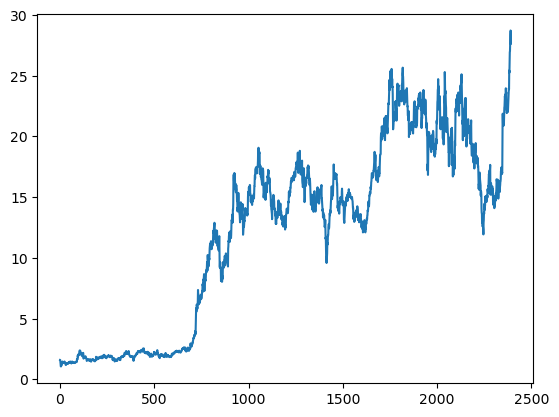

In [23]:
plt.plot(df.Close)

In [25]:
ma100 = df.Close.rolling(100).mean()
ma100

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
2388    18.778527
2389    18.905800
2390    19.040880
2391    19.173967
2392    19.294820
Name: Close, Length: 2393, dtype: float64

In [29]:
ma200 = df.Close.rolling(200).mean()
ma200

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
2388    17.430070
2389    17.477367
2390    17.524693
2391    17.571500
2392    17.617923
Name: Close, Length: 2393, dtype: float64

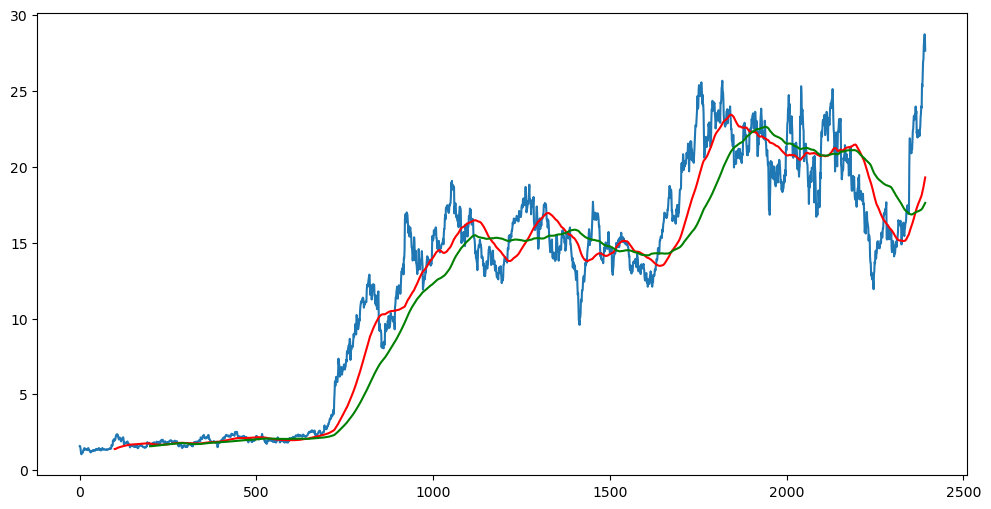

In [31]:
plt.figure(figsize=(12,6))
plt.plot(df.Close)
plt.plot(ma100, c='r')
plt.plot(ma200, c='g')

In [35]:
df.shape

(2393, 5)

In [34]:
# Splitting into training and testing data

data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.70):int(len(df))])

print(data_training.shape, data_testing.shape)

(1675, 1) (718, 1)


In [39]:
#Scale the feature

scaler = MinMaxScaler(feature_range=(0,1))

In [40]:
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.02993639],
       [0.02971437],
       [0.02279457],
       ...,
       [0.94889733],
       [0.96799146],
       [0.95363383]])

In [42]:
X_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    X_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [44]:
X_train.shape

(1575, 100, 1)

In [45]:
# ML Model

model = Sequential()
model.add(LSTM(units = 50,
               activation = 'relu',
               return_sequences=True,
               input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60,
               activation = 'relu',
               return_sequences=True,
               ))
model.add(Dropout(0.3))

model.add(LSTM(units = 80,
               activation = 'relu',
               return_sequences=True,
               ))
model.add(Dropout(0.4))

model.add(LSTM(units = 120,
               activation = 'relu',
               ))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

2023-11-25 15:29:12.301096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [47]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs = 50)

Epoch 1/50
50/50 [==============================] - 13s 173ms/step - loss: 0.0810
Epoch 2/50
50/50 [==============================] - 9s 176ms/step - loss: 0.0156
Epoch 3/50
50/50 [==============================] - 9s 190ms/step - loss: 0.0130
Epoch 4/50
50/50 [==============================] - 10s 205ms/step - loss: 0.0123
Epoch 5/50
50/50 [==============================] - 10s 196ms/step - loss: 0.0120
Epoch 6/50
50/50 [==============================] - 9s 182ms/step - loss: 0.0114
Epoch 7/50
50/50 [==============================] - 10s 195ms/step - loss: 0.0111
Epoch 8/50
50/50 [==============================] - 10s 199ms/step - loss: 0.0098
Epoch 9/50
50/50 [==============================] - 11s 211ms/step - loss: 0.0099
Epoch 10/50
50/50 [==============================] - 10s 207ms/step - loss: 0.0087
Epoch 11/50
50/50 [==============================] - 10s 206ms/step - loss: 0.0089
Epoch 12/50
50/50 [==============================] - 10s 204ms/step - loss: 0.0090
Epoch 13/50
50/5

In [48]:
model.save('keras_model.h5')

In [49]:
data_testing.head()

,Close
1675,17.066000
1676,17.133333
1677,16.415333
1678,16.666000
1679,16.667999


In [53]:
past_100_days = data_training.tail(100)

In [54]:
past_100_days

,Close
1575,13.380000
1576,13.602000
1577,14.246667
1578,14.094000
1579,13.897333
...,...
1670,18.650667
1671,17.930000
1672,18.148666
1673,18.492666


In [57]:
final_df = pd.concat([past_100_days,data_testing], axis=0)

In [59]:
final_df.tail()

,Close
2388,27.948000
2389,28.350000
2390,28.729334
2391,28.691999
2392,27.646667


In [60]:
input_data = scaler.fit_transform(final_df)
input_data

array([[0.08624047],
       [0.09945634],
       [0.13783392],
       [0.12874551],
       [0.11703777],
       [0.08743106],
       [0.07000836],
       [0.08723264],
       [0.08385924],
       [0.08945513],
       [0.08441482],
       [0.06961152],
       [0.05949126],
       [0.07989046],
       [0.09759106],
       [0.07989046],
       [0.0838195 ],
       [0.09441602],
       [0.09274916],
       [0.09235232],
       [0.09937697],
       [0.08334328],
       [0.07445336],
       [0.04691035],
       [0.03591704],
       [0.0335358 ],
       [0.04599761],
       [0.05651471],
       [0.06338062],
       [0.04401322],
       [0.02532051],
       [0.03806016],
       [0.00984252],
       [0.01904992],
       [0.01968493],
       [0.03845701],
       [0.02401087],
       [0.02202648],
       [0.04841853],
       [0.05623692],
       [0.0701671 ],
       [0.06806372],
       [0.04206851],
       [0.04139388],
       [0.01154901],
       [0.00992183],
       [0.03107514],
       [0.027

In [61]:
input_data.shape

(818, 1)

In [62]:
X_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    X_test.append(input_data[i-100:i])
    y_test.append(input_data[i,0])

In [63]:
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape)
print(y_test.shape)

(718, 100, 1)
(718,)


In [64]:
# Making Predictions
y_predicted = model.predict(X_test)

23/23 [==============================] - 3s 84ms/step


In [65]:
y_predicted.shape

(718, 1)

In [66]:
y_test

array([0.30567133, 0.30967974, 0.26693653, 0.281859  , 0.28197799,
       0.2838037 , 0.28812958, 0.28670083, 0.27630273, 0.26947656,
       0.26165822, 0.25685602, 0.26669843, 0.31364852, 0.30463954,
       0.32972177, 0.32753896, 0.32920582, 0.28459739, 0.30178203,
       0.30086912, 0.33412713, 0.36214635, 0.39084026, 0.39056242,
       0.39270549, 0.39421361, 0.47446122, 0.49501933, 0.46049141,
       0.47517566, 0.49041548, 0.5295075 , 0.51490262, 0.46779379,
       0.49620986, 0.48604997, 0.48132713, 0.50224234, 0.49029649,
       0.50255981, 0.51220386, 0.53506365, 0.52069688, 0.51458503,
       0.53617493, 0.57094095, 0.55530416, 0.52407034, 0.46231689,
       0.51347387, 0.50887014, 0.5647101 , 0.58042625, 0.5720126 ,
       0.57879902, 0.54335831, 0.54784305, 0.50458389, 0.53216652,
       0.52331628, 0.52141132, 0.49565428, 0.52089536, 0.54712861,
       0.58010878, 0.61963726, 0.64309238, 0.64055247, 0.63848877,
       0.6681351 , 0.6900821 , 0.71706953, 0.75814587, 0.70782

In [67]:
y_predicted

array([[0.3562603 ],
       [0.3615744 ],
       [0.36420554],
       [0.36412573],
       [0.36163604],
       [0.3571964 ],
       [0.3513705 ],
       [0.3447734 ],
       [0.3379975 ],
       [0.33152008],
       [0.3256176 ],
       [0.32039088],
       [0.315821  ],
       [0.3118897 ],
       [0.30885822],
       [0.30691552],
       [0.3062924 ],
       [0.30707985],
       [0.30916977],
       [0.31185398],
       [0.31450868],
       [0.31672925],
       [0.3185469 ],
       [0.32034665],
       [0.32285672],
       [0.32670552],
       [0.33212596],
       [0.33894384],
       [0.34783685],
       [0.3596325 ],
       [0.37380219],
       [0.389342  ],
       [0.4053126 ],
       [0.42159116],
       [0.43764597],
       [0.45178217],
       [0.46314704],
       [0.47128463],
       [0.4762643 ],
       [0.4787888 ],
       [0.4795196 ],
       [0.47923082],
       [0.47874755],
       [0.47918975],
       [0.4810332 ],
       [0.4841085 ],
       [0.48838693],
       [0.494

In [71]:
scaler.scale_[0]

0.05953089196587642

In [69]:
scale_factor = 1/0.05953089
y_predicted = y_predicted * scale_factor
y_test = y_test*scale_factor

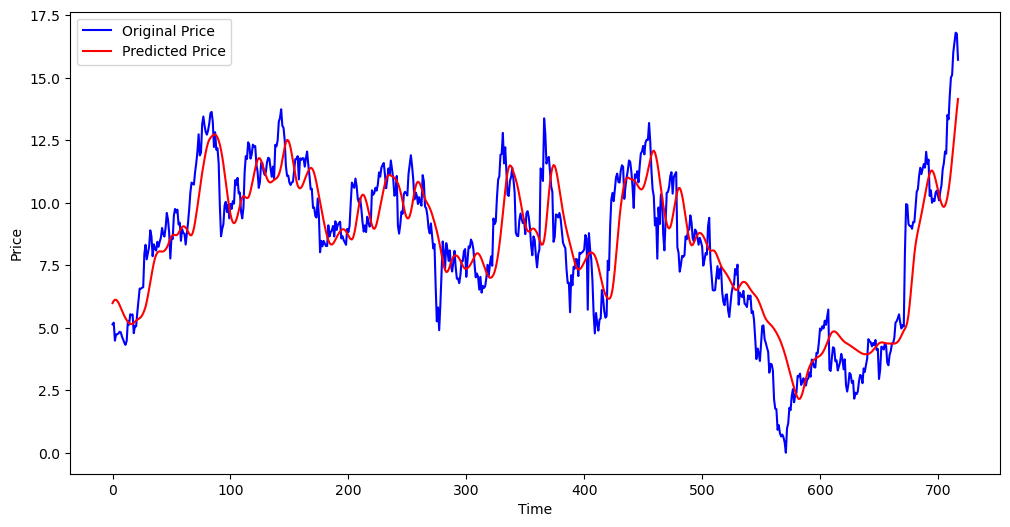

In [70]:
plt.figure(figsize = (12,6))
plt.plot(y_test,'b',label = 'Original Price')
plt.plot(y_predicted, 'r', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()